In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno
from collections import Counter
from itertools import chain, combinations
import sklearn as sk
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report

# Performance comparison

In this notebook we compare the performance of multiple models on different subsets of our data.
#### The models are:
+ Logistic Regression
+ SVM
+ KNN
+ Neural Network
+ XGBoost

#### The datasets:
+ Mean/Mode imputed
+ KNN imputed
+ MICE imputed
+ no imputations

#### The targets:
+ has_dep_diag
+ a binary combination of all the target variables

#### In combinations of:
+ trained on balanced, tested on balanced
+ trained on balanced, tested on imbalanced
+ trained on imbalanced, tested on balanced
+ trained on imbalanced, tested on imbalanced

#### We employ  range of visualisation methods:
+ ROC curves
+ bar plots
+ learning curves

The iputed datasets:
+ 0 - unedited
+ 1 - Mean/Mode
+ 2/3? - drop NaN
+ 4 - K-Means
+ 5 - MICE

In [148]:
data0 = pd.read_csv("newdata3.csv", engine='python')
data1 = pd.read_csv("imputed_dataset_1.csv", engine='python').drop(['Unnamed: 0'], axis = 1)
data2 = pd.read_csv("imputed_dataset_2.csv", engine='python').drop(['Unnamed: 0'], axis = 1)
data3 = pd.read_csv("imputed_dataset_3.csv", engine='python').drop(['Unnamed: 0'], axis = 1)
data4 = pd.read_csv("imputed_dataset_4.csv", engine='python').drop(['Unnamed: 0'], axis = 1)
data5 = pd.read_csv("imputed_dataset_5.csv", engine='python').drop(['Unnamed: 0'], axis = 1)

### dataset 5 - combined variable (dep)

In [149]:
data = pd.read_csv("imputed_dataset_5.csv", engine='python').drop(['Unnamed: 0'], axis = 1)
dep_data = data.copy()

dep_num = np.array([12, 11, 10, 4])
no_dep_num = np.setdiff1d(range(13), dep_num)

dep_data[['prim_diag', 'secd_diag']] = dep_data[['prim_diag', 'secd_diag']].replace(list(no_dep_num), 0)
dep_data[['prim_diag', 'secd_diag']] = dep_data[['prim_diag', 'secd_diag']].replace(list(dep_num), 1)

In [150]:
full = data.dropna(axis = 0, how = 'any')
dep = [x for x in data.columns if 'dep' in x or 'diag' in x or 'panic' in x]
dep_data['dep'] = dep_data['secd_diag'] + dep_data['prim_diag'] + 0 * dep_data['has_dep_diag']
dep_data['dep'] = dep_data['dep'].replace(range(2, 4), 1)
full = dep_data.dropna(axis = 0, how = 'any')
dep = [x for x in data.columns if 'dep' in x or 'diag' in x or 'panic' in x]

In [151]:
has_dep = full.query('dep == 1')
no_dep = full.query('dep == 0')
size = int(np.round(0.8 * min(len(has_dep), len(no_dep))))
sample = full.sample(8000)

sample = sample.sort_index()
sample = sample.reset_index(drop = True)


X_comb = sample.drop(dep, axis = 1).drop('dep', axis = 1)
Y_comb = sample['dep']
print('dataset shape %s' % Counter(Y_comb))

dataset shape Counter({0.0: 7719, 1.0: 281})


### dataset 5 - has_dep_diag

In [152]:
X_hasdep = data5.drop(['has_dep_diag'],axis=1).drop(['secd_diag'],axis=1).drop(['prim_diag'],axis=1).drop(['dep_score'],axis=1).drop(['dep_thoughts'],axis=1).drop(['panic_score'], axis=1).drop(['dep_band_15'], axis=1)
print(X_hasdep.shape)
Y_hasdep = np.array(data5['has_dep_diag'])
print(Y_hasdep.shape)
print('dataset shape %s' % Counter(Y_hasdep))

(13734, 35)
(13734,)
dataset shape Counter({0.0: 13344, 1.0: 390})


### Over/undersampling to obtain imbalanced and balanced datasets

Random undersampling, no SMOTE.

In [153]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 
from imblearn import under_sampling

nb = 250
nl = 3760
ns = 240


#combined, imbalanced (original ratio), undersampling
rus = under_sampling.RandomUnderSampler(sampling_strategy={1.0: ns, 0.0: nl}, random_state=42)
X_combined_imb, Y_combined_imb = rus.fit_resample(X_comb, Y_comb)
print(X_combined_imb.shape)
print(Y_combined_imb.shape)
print('Resampled dataset shape %s' % Counter(Y_combined_imb))

#combined, balanced, undersampling
rus = under_sampling.RandomUnderSampler(sampling_strategy={1.0: nb, 0.0: nb}, random_state=42)
X_combined_b, Y_combined_b = rus.fit_resample(X_comb, Y_comb)
print(X_combined_b.shape)
print(Y_combined_b.shape)
print('Resampled dataset shape %s' % Counter(Y_combined_b))

#has_dep_diag, imbalanced (original ratio), undersampling
rus = under_sampling.RandomUnderSampler(sampling_strategy={1.0: ns, 0.0: nl}, random_state=42)
X_hasdep_imb, Y_hasdep_imb = rus.fit_resample(X_hasdep, Y_hasdep)
print(X_hasdep_imb.shape)
print(Y_hasdep_imb.shape)
print('Resampled dataset shape %s' % Counter(Y_hasdep_imb))

#has_dep_diag, balanced, undersampling
rus = under_sampling.RandomUnderSampler(sampling_strategy={1.0: nb, 0.0: nb}, random_state=42)
X_hasdep_b, Y_hasdep_b = rus.fit_resample(X_hasdep, Y_hasdep)
print(X_hasdep_b.shape)
print(Y_hasdep_b.shape)
print('Resampled dataset shape %s' % Counter(Y_hasdep_b))


(4000, 35)
(4000,)
Resampled dataset shape Counter({0.0: 3760, 1.0: 240})
(500, 35)
(500,)
Resampled dataset shape Counter({0.0: 250, 1.0: 250})
(4000, 35)
(4000,)
Resampled dataset shape Counter({0.0: 3760, 1.0: 240})
(500, 35)
(500,)
Resampled dataset shape Counter({0.0: 250, 1.0: 250})


SMOTE increases the scores but can't be trusted.

In [154]:
"""

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 
from imblearn import under_sampling

nb = 400
nl = 3760
ns = 240


#combined, imbalanced (original ratio), undersampling
smoteenn = SMOTEENN(random_state = 42, sampling_strategy=0.1)
rus = under_sampling.RandomUnderSampler(sampling_strategy={1.0: ns, 0.0: nl}, random_state=42)
X_combined_imb, Y_combined_imb = smoteenn.fit_resample(X_comb, Y_comb)
print(X_combined_imb.shape)
print(Y_combined_imb.shape)
print('Resampled dataset shape %s' % Counter(Y_combined_imb))
X_combined_imb, Y_combined_imb = rus.fit_resample(X_combined_imb, Y_combined_imb)
print(X_combined_imb.shape)
print(Y_combined_imb.shape)
print('Resampled dataset shape %s' % Counter(Y_combined_imb))

#combined, imbalanced (original ratio), oversampling

#combined, balanced, undersampling
smoteenn = SMOTEENN(random_state = 42, sampling_strategy=0.1)
rus = under_sampling.RandomUnderSampler(sampling_strategy={1.0: nb, 0.0: nb}, random_state=42)
X_combined_b, Y_combined_b = smoteenn.fit_resample(X_comb, Y_comb)
X_combined_b, Y_combined_b = rus.fit_resample(X_combined_b, Y_combined_b)
#rusboost.fit(X_combined_b, Y_combined_b)
#Y_combined_b = rusboost.predict(X_combined_b)
print(X_combined_b.shape)
print(Y_combined_b.shape)
print('Resampled dataset shape %s' % Counter(Y_combined_b))

#combined, balanced, oversampling

#has_dep_diag, imbalanced (original ratio), undersampling
smoteenn = SMOTEENN(random_state = 42, sampling_strategy=0.1)
rus = under_sampling.RandomUnderSampler(sampling_strategy={1.0: ns, 0.0: nl}, random_state=42)
X_hasdep_imb, Y_hasdep_imb = smoteenn.fit_resample(X_hasdep, Y_hasdep)
X_hasdep_imb, Y_hasdep_imb = rus.fit_resample(X_hasdep_imb, Y_hasdep_imb)
print(X_hasdep_imb.shape)
print(Y_hasdep_imb.shape)
print('Resampled dataset shape %s' % Counter(Y_hasdep_imb))

#has_dep_diag, imbalanced (original ratio), oversampling

#has_dep_diag, balanced, undersampling
smoteenn = SMOTEENN(random_state = 42, sampling_strategy=0.1)
rus = under_sampling.RandomUnderSampler(sampling_strategy={1.0: nb, 0.0: nb}, random_state=42)
X_hasdep_b, Y_hasdep_b = smoteenn.fit_resample(X_hasdep, Y_hasdep)
X_hasdep_b, Y_hasdep_b = rus.fit_resample(X_hasdep_b, Y_hasdep_b)
print(X_hasdep_b.shape)
print(Y_hasdep_b.shape)
print('Resampled dataset shape %s' % Counter(Y_hasdep_b))

#has_dep_diag, balanced, oversampling

"""

"\n\nimport imblearn\nfrom imblearn.over_sampling import SMOTE\nfrom imblearn.combine import SMOTEENN \nfrom imblearn import under_sampling\n\nnb = 400\nnl = 3760\nns = 240\n\n\n#combined, imbalanced (original ratio), undersampling\nsmoteenn = SMOTEENN(random_state = 42, sampling_strategy=0.1)\nrus = under_sampling.RandomUnderSampler(sampling_strategy={1.0: ns, 0.0: nl}, random_state=42)\nX_combined_imb, Y_combined_imb = smoteenn.fit_resample(X_comb, Y_comb)\nprint(X_combined_imb.shape)\nprint(Y_combined_imb.shape)\nprint('Resampled dataset shape %s' % Counter(Y_combined_imb))\nX_combined_imb, Y_combined_imb = rus.fit_resample(X_combined_imb, Y_combined_imb)\nprint(X_combined_imb.shape)\nprint(Y_combined_imb.shape)\nprint('Resampled dataset shape %s' % Counter(Y_combined_imb))\n\n#combined, imbalanced (original ratio), oversampling\n\n#combined, balanced, undersampling\nsmoteenn = SMOTEENN(random_state = 42, sampling_strategy=0.1)\nrus = under_sampling.RandomUnderSampler(sampling_strat

In [155]:
"""
nl = 3760
ns = 240

svm.fit(X_train_comb_imb, y_train_comb_imb)
y_pred = svm.predict(X_test_comb_imb)
print(f1_score(y_pred, y_test_comb_imb, average = 'macro'))
print(f'accuracy: {svm.score(X_test_comb_imb, y_test_comb_imb)}')
print(f'recall: {recall_score(y_pred, y_test_comb_imb)}')
print(f'precision: {precision_score(y_pred, y_test_comb_imb)}')

#combined, imbalanced (original ratio), undersampling
smoteenn = SMOTEENN(random_state = 42, sampling_strategy=0.1)
rus = under_sampling.RandomUnderSampler(sampling_strategy={1.0: ns, 0.0: nl}, random_state=42)
X_combined_imb, Y_combined_imb = smoteenn.fit_resample(X_comb, Y_comb)
print(X_combined_imb.shape)
print(Y_combined_imb.shape)
print('Resampled dataset shape %s' % Counter(Y_combined_imb))
X_combined_imb, Y_combined_imb = rus.fit_resample(X_combined_imb, Y_combined_imb)
print(X_combined_imb.shape)
print(Y_combined_imb.shape)
print('Resampled dataset shape %s' % Counter(Y_combined_imb))

#combined, imbalanced (original ratio), undersampling
X_train_comb_imb, X_test_comb_imb, y_train_comb_imb, y_test_comb_imb = split_dataset(0.2, Y_combined_imb.size, X_combined_imb, Y_combined_imb)
print(X_train_comb_imb.shape); print(X_test_comb_imb.shape)
print(y_train_comb_imb.shape); print(y_test_comb_imb.shape)

svm = SVC(C=5, gamma='auto', kernel='rbf')

#combined variable

#train imbalanced, test imbalanced
svm.fit(X_train_comb_imb, y_train_comb_imb)
y_pred = svm.predict(X_test_comb_imb)
print(f1_score(y_pred, y_test_comb_imb, average = 'macro'))
print(f'accuracy: {svm.score(X_test_comb_imb, y_test_comb_imb)}')
print(f'recall: {recall_score(y_pred, y_test_comb_imb)}')
print(f'precision: {precision_score(y_pred, y_test_comb_imb)}')

"""

"\nnl = 3760\nns = 240\n\nsvm.fit(X_train_comb_imb, y_train_comb_imb)\ny_pred = svm.predict(X_test_comb_imb)\nprint(f1_score(y_pred, y_test_comb_imb, average = 'macro'))\nprint(f'accuracy: {svm.score(X_test_comb_imb, y_test_comb_imb)}')\nprint(f'recall: {recall_score(y_pred, y_test_comb_imb)}')\nprint(f'precision: {precision_score(y_pred, y_test_comb_imb)}')\n\n#combined, imbalanced (original ratio), undersampling\nsmoteenn = SMOTEENN(random_state = 42, sampling_strategy=0.1)\nrus = under_sampling.RandomUnderSampler(sampling_strategy={1.0: ns, 0.0: nl}, random_state=42)\nX_combined_imb, Y_combined_imb = smoteenn.fit_resample(X_comb, Y_comb)\nprint(X_combined_imb.shape)\nprint(Y_combined_imb.shape)\nprint('Resampled dataset shape %s' % Counter(Y_combined_imb))\nX_combined_imb, Y_combined_imb = rus.fit_resample(X_combined_imb, Y_combined_imb)\nprint(X_combined_imb.shape)\nprint(Y_combined_imb.shape)\nprint('Resampled dataset shape %s' % Counter(Y_combined_imb))\n\n#combined, imbalanced (

In [156]:
def plot_smote_to_F1(smote_ratio_start, smote_ratio_end, ns, nl):
    xs = np.array([])
    ys = np.array([])
    for n in range(smote_ratio_start, smote_ratio_end):
        nd = n/100
        xs = np.append(xs, nd)
        #combined, imbalanced (original ratio), undersampling
        smoteenn = SMOTEENN(random_state = 42, sampling_strategy=nd)
        rus = under_sampling.RandomUnderSampler(sampling_strategy={1.0: ns, 0.0: nl}, random_state=42)
        X_combined_imb, Y_combined_imb = smoteenn.fit_resample(X_comb, Y_comb)
        print('Resampled dataset shape %s' % Counter(Y_combined_imb))
        X_combined_imb, Y_combined_imb = rus.fit_resample(X_combined_imb, Y_combined_imb)

        #train-test split
        X_train_comb_imb, X_test_comb_imb, y_train_comb_imb, y_test_comb_imb = split_dataset(0.2, Y_combined_imb.size, X_combined_imb, Y_combined_imb)

        svm = SVC(C=5, gamma='auto', kernel='rbf')

        #train imbalanced, test imbalanced
        svm.fit(X_train_comb_imb, y_train_comb_imb)
        y_pred = svm.predict(X_test_comb_imb)
        print(f1_score(y_pred, y_test_comb_imb, average = 'macro'))
        ys = np.append(ys, f1_score(y_pred, y_test_comb_imb, average = 'macro'))
        
    plt.plot(xs, ys)
    plt.title('SMOTE ratio to F1 score')
    plt.xlabel('SMOTE ratio')
    plt.ylabel('F1 score')
    plt.show()

Resampled dataset shape Counter({0.0: 6453, 1.0: 461})
0.8723704902340634
Resampled dataset shape Counter({0.0: 6442, 1.0: 514})
0.9158249158249159
Resampled dataset shape Counter({0.0: 6382, 1.0: 636})
0.8538650316493397
Resampled dataset shape Counter({0.0: 6363, 1.0: 752})
0.8289473684210527
Resampled dataset shape Counter({0.0: 6323, 1.0: 823})
0.8113143973853567
Resampled dataset shape Counter({0.0: 6309, 1.0: 931})
0.8446903513880799
Resampled dataset shape Counter({0.0: 6261, 1.0: 1035})
0.8328995147658986
Resampled dataset shape Counter({0.0: 6262, 1.0: 1114})
0.8723704902340634
Resampled dataset shape Counter({0.0: 6247, 1.0: 1219})
0.8115341123256691
Resampled dataset shape Counter({0.0: 6208, 1.0: 1289})
0.8066031219781737
Resampled dataset shape Counter({0.0: 6182, 1.0: 1401})
0.838269483473163
Resampled dataset shape Counter({0.0: 6161, 1.0: 1472})
0.7273904450350984
Resampled dataset shape Counter({0.0: 6129, 1.0: 1576})
0.7649133117837202
Resampled dataset shape Counter(

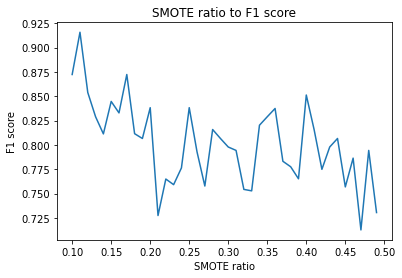

In [157]:
plot_smote_to_F1(10, 50, 240, 3760)

### Train/test split function

In [158]:
from random import shuffle
from sklearn.model_selection import train_test_split

def shuffle_dataset(N, X, y, X_shuffled, y_shuffled):
    ind_list = [i for i in range(N)]
    shuffle(ind_list)
    X_shuffled  = X.iloc[ind_list]
    y_shuffled = y.iloc[ind_list]
    
def split_dataset(split, N, X, y):
    X_shuffled = X
    y_shuffled = y
    shuffle_dataset(N, pd. DataFrame(X), pd. DataFrame(y), pd. DataFrame(X_shuffled), pd. DataFrame(y_shuffled))
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled,test_size=split, random_state=40)
    return X_train, X_test, y_train, y_test

In [159]:
#combined, imbalanced (original ratio), undersampling
X_train_comb_imb, X_test_comb_imb, y_train_comb_imb, y_test_comb_imb = split_dataset(0.2, Y_combined_imb.size, X_combined_imb, Y_combined_imb)
print(X_train_comb_imb.shape); print(X_test_comb_imb.shape)
print(y_train_comb_imb.shape); print(y_test_comb_imb.shape)

#combined, balanced, undersampling
X_train_comb_b, X_test_comb_b, y_train_comb_b, y_test_comb_b = split_dataset(0.2, Y_combined_b.size, X_combined_b, Y_combined_b)
print(X_train_comb_b.shape); print(X_test_comb_b.shape)
print(y_train_comb_b.shape); print(y_test_comb_b.shape)

#has_dep_diag, imbalanced (original ratio), undersampling
X_train_hasdep_imb, X_test_hasdep_imb, y_train_hasdep_imb, y_test_hasdep_imb = split_dataset(0.2, Y_hasdep_imb.size, X_hasdep_imb, Y_hasdep_imb)
print(X_train_hasdep_imb.shape); print(X_test_hasdep_imb.shape)
print(y_train_hasdep_imb.shape); print(y_test_hasdep_imb.shape)

#has_dep_diag, balanced, undersampling
X_train_hasdep_b, X_test_hasdep_b, y_train_hasdep_b, y_test_hasdep_b = split_dataset(0.2, Y_hasdep_b.size, X_hasdep_b, Y_hasdep_b)
print(X_train_hasdep_b.shape); print(X_test_hasdep_b.shape)
print(y_train_hasdep_b.shape); print(y_test_hasdep_b.shape)

(3200, 35)
(800, 35)
(3200,)
(800,)
(400, 35)
(100, 35)
(400,)
(100,)
(3200, 35)
(800, 35)
(3200,)
(800,)
(400, 35)
(100, 35)
(400,)
(100,)


## Plotting Functions

Learning curve:

In [160]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score, make_scorer

scorer = make_scorer(f1_score, average = 'macro')


#plot learning curve function from the labs
def plot_learning_curve(n, est, xs, ys, title):
    train_sizes, train_scores, valid_scores = learning_curve(estimator = est, X = xs, y = ys, cv = n, scoring=scorer)

    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', label='Training score')
    plt.plot(train_sizes, valid_mean, color='green', label='Validation score')

    plt.xlabel('Dataset size')
    plt.ylabel('F1 score')
    plt.title(title)
    plt.legend()
    plt.show()

ROC Curve:

In [161]:
import sklearn.metrics

def plot_roc(model, X_train, y_train, X_test, y_test, title):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, preds)
    roc_auc = sklearn.metrics.auc(fpr, tpr)


    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Confusion Matrix:

In [162]:
from sklearn.metrics import plot_confusion_matrix

#plot_confusion_matrix(model, X_test, y_test)  
def plot_cf(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    plot_confusion_matrix(model, X_test, y_test)  

Print precision, recall, F1

In [163]:
def print_metrics(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    f1 = f1_score(preds, y_test, average = 'macro')
    print(model_name + ': ')
    print(f'F1: {f1}')
    recall = recall_score(y_test, preds, average = 'macro')
    print(f'recall: {recall}')
    precision = precision_score(y_test, preds, average = 'macro')
    print(f'precision: {precision}')
    print(f'accuracy: {model.score(X_test, y_test)}')

## Models

### Logistic Regression

In [164]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty = 'l2', max_iter = 1000, C = 1e-07, solver = 'newton-cg')

0.4842037395228885
0.0
[751  49] [800]


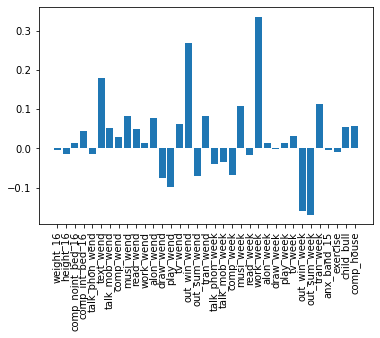

0.3333333333333333
0.0
[50 50] [100]


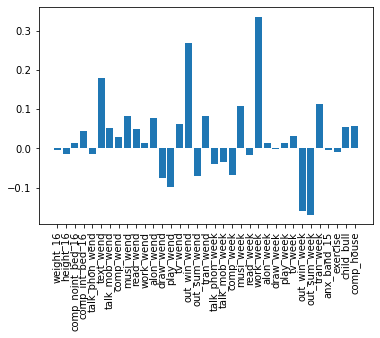

0.45464019227640357
0.7755102040816326
[751  49] [442 358]


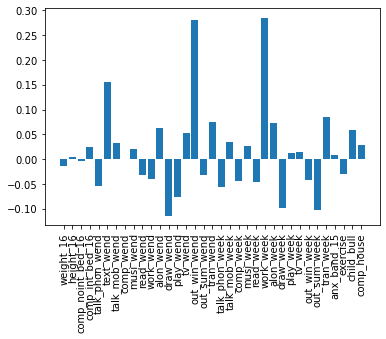

0.7159090909090909
0.84
[50 50] [38 62]


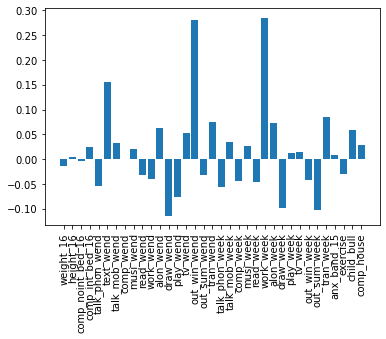

0.4842037395228885
0.0
[751  49] [800]


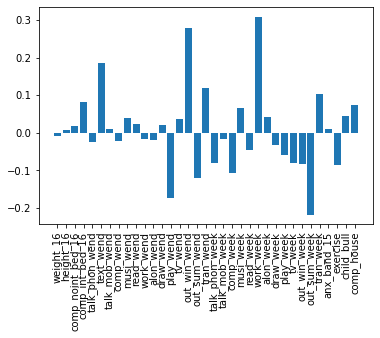

0.3333333333333333
0.0
[50 50] [100]


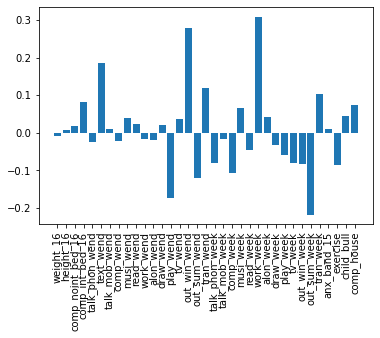

0.4392121654002744
0.7551020408163265
[751  49] [426 374]


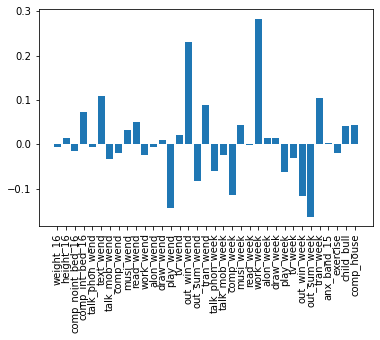

0.6550324675324675
0.78
[50 50] [38 62]


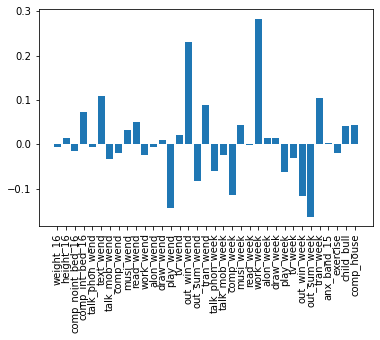

In [165]:
#normal data and weights

clf = LogisticRegression(penalty = 'l2', max_iter = 1000, C = 0.01, solver = 'newton-cg')
#combined variable

#train imbalanced, test imbalanced
clf.fit(X_train_comb_imb, y_train_comb_imb)
y_pred = clf.predict(X_test_comb_imb)
print(f1_score(y_test_comb_imb, y_pred, average = 'macro'))
print(recall_score(y_test_comb_imb, y_pred, pos_label = 1))
print(np.bincount(y_test_comb_imb.astype('int')), np.bincount(y_pred.astype('int')))
plt.bar(X_combined_b.columns, clf.coef_.reshape(35,))
plt.xticks(rotation = 90)
plt.show()

#train imbalanced, test balanced
clf.fit(X_train_comb_imb, y_train_comb_imb)
y_pred = clf.predict(X_test_comb_b)
print(f1_score(y_test_comb_b,y_pred, average = 'macro'))
print(recall_score(y_test_comb_b, y_pred, pos_label = 1))
print(np.bincount(y_test_comb_b.astype('int')), np.bincount(y_pred.astype('int')))
plt.bar(X_combined_b.columns, clf.coef_.reshape(35,))
plt.xticks(rotation = 90)
plt.show()

#train balanced, test imbalanced
clf.fit(X_train_comb_b, y_train_comb_b)
y_pred = clf.predict(X_test_comb_imb)
print(f1_score(y_test_comb_imb, y_pred, average = 'macro'))
print(recall_score(y_test_comb_imb, y_pred, pos_label = 1))
print(np.bincount(y_test_comb_imb.astype('int')), np.bincount(y_pred.astype('int')))
plt.bar(X_combined_b.columns, clf.coef_.reshape(35,))
plt.xticks(rotation = 90)
plt.show()

#train balanced, test balanced
clf.fit(X_train_comb_b, y_train_comb_b)
y_pred = clf.predict(X_test_comb_b)
print(f1_score(y_pred, y_test_comb_b, average = 'macro'))
print(recall_score(y_test_comb_b, y_pred, pos_label = 1))
print(np.bincount(y_test_comb_b.astype('int')), np.bincount(y_pred.astype('int')))
plt.bar(X_combined_b.columns, clf.coef_.reshape(35,))
plt.xticks(rotation = 90)
plt.show()

#has_dep_diag

#train imbalanced, test imbalanced
clf.fit(X_train_hasdep_imb, y_train_hasdep_imb)
y_pred = clf.predict(X_test_hasdep_imb)
print(f1_score(y_pred, y_test_hasdep_imb, average = 'macro'))
print(recall_score(y_test_hasdep_imb, y_pred, pos_label = 1))
print(np.bincount(y_test_hasdep_imb.astype('int')), np.bincount(y_pred.astype('int')))
plt.bar(X_combined_b.columns, clf.coef_.reshape(35,))
plt.xticks(rotation = 90)
plt.show()

#train imbalanced, test balanced
clf.fit(X_train_hasdep_imb, y_train_hasdep_imb)
y_pred = clf.predict(X_test_hasdep_b)
print(f1_score(y_pred, y_test_hasdep_b, average = 'macro'))
print(recall_score(y_test_hasdep_b, y_pred, pos_label = 1))
print(np.bincount(y_test_hasdep_b.astype('int')), np.bincount(y_pred.astype('int')))
plt.bar(X_combined_b.columns, clf.coef_.reshape(35,))
plt.xticks(rotation = 90)
plt.show()

#train balanced, test imbalanced
clf.fit(X_train_hasdep_b, y_train_hasdep_b)
y_pred = clf.predict(X_test_hasdep_imb)
print(f1_score(y_pred, y_test_hasdep_imb, average = 'macro'))
print(recall_score(y_test_hasdep_imb, y_pred, pos_label = 1))
print(np.bincount(y_test_hasdep_imb.astype('int')), np.bincount(y_pred.astype('int')))
plt.bar(X_combined_b.columns, clf.coef_.reshape(35,))
plt.xticks(rotation = 90)
plt.show()

#train balanced, test balanced
clf.fit(X_train_hasdep_b, y_train_hasdep_b)
y_pred = clf.predict(X_test_hasdep_b)
print(f1_score(y_pred, y_test_hasdep_b, average = 'macro'))
print(recall_score(y_test_hasdep_b, y_pred, pos_label = 1))
print(np.bincount(y_test_hasdep_b.astype('int')), np.bincount(y_pred.astype('int')))
plt.bar(X_combined_b.columns, clf.coef_.reshape(35,))
plt.xticks(rotation = 90)
plt.show()

Logistic regression, combined, imbalanced: 
F1: 0.4842037395228885
recall: 0.5
precision: 0.469375
accuracy: 0.93875
Logistic regression, combined, balanced: 
F1: 0.7159090909090909
recall: 0.72
precision: 0.733446519524618
accuracy: 0.72
Logistic regression, has_dep_diag, imbalanced: 
F1: 0.4842037395228885
recall: 0.5
precision: 0.469375
accuracy: 0.93875
Logistic regression, has_dep_diag, balanced: 
F1: 0.6550324675324675
recall: 0.66
precision: 0.669779286926995
accuracy: 0.66


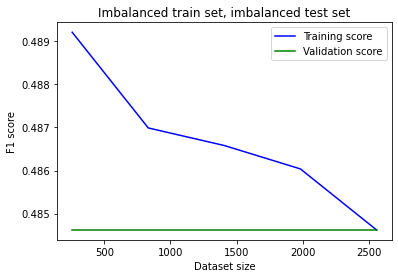

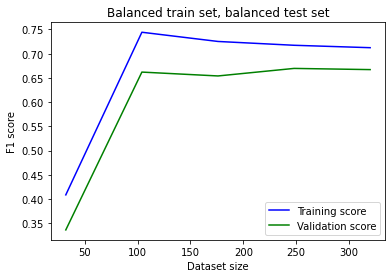

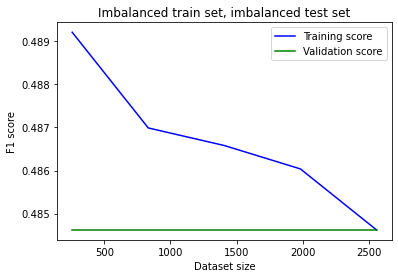

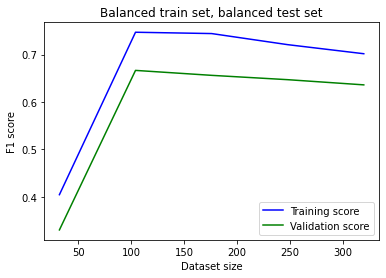

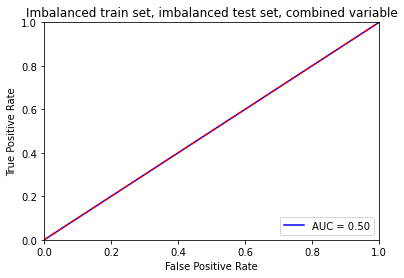

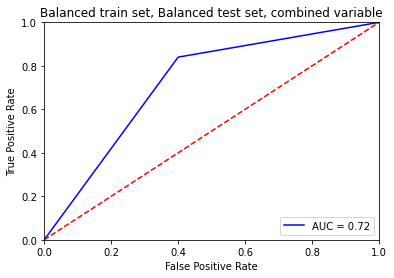

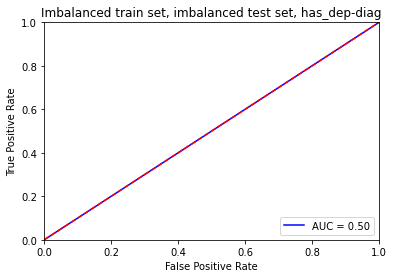

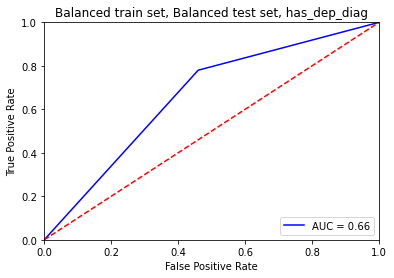

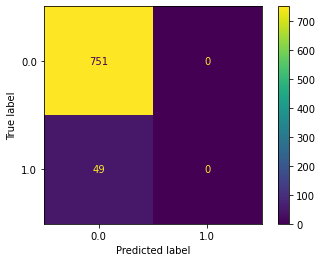

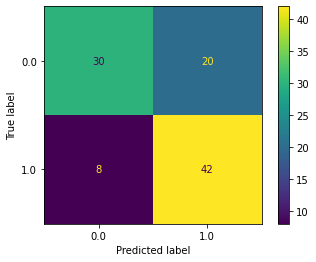

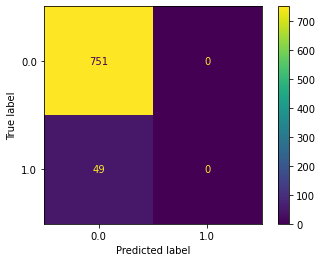

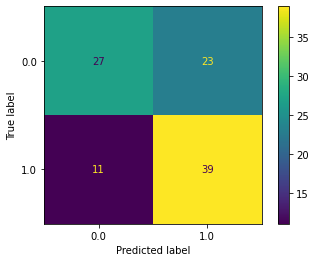

In [166]:
print_metrics(clf, X_train_comb_imb, y_train_comb_imb, X_test_comb_imb, y_test_comb_imb, "Logistic regression, combined, imbalanced")
print_metrics(clf, X_train_comb_b, y_train_comb_b, X_test_comb_b, y_test_comb_b, "Logistic regression, combined, balanced")
print_metrics(clf, X_train_hasdep_imb, y_train_hasdep_imb, X_test_hasdep_imb, y_test_hasdep_imb, "Logistic regression, has_dep_diag, imbalanced")
print_metrics(clf, X_train_hasdep_b, y_train_hasdep_b, X_test_hasdep_b, y_test_hasdep_b, "Logistic regression, has_dep_diag, balanced")

plot_learning_curve(5, clf, X_train_comb_imb, y_train_comb_imb, 'Imbalanced train set, imbalanced test set')
plot_learning_curve(5, clf, X_train_comb_b, y_train_comb_b, 'Balanced train set, balanced test set')
plot_learning_curve(5, clf, X_train_hasdep_imb, y_train_hasdep_imb, 'Imbalanced train set, imbalanced test set')
plot_learning_curve(5, clf, X_train_hasdep_b, y_train_hasdep_b, 'Balanced train set, balanced test set')

plot_roc(clf, X_train_comb_imb, y_train_comb_imb, X_test_comb_imb, y_test_comb_imb, "Imbalanced train set, imbalanced test set, combined variable")
plot_roc(clf, X_train_comb_b, y_train_comb_b, X_test_comb_b, y_test_comb_b, "Balanced train set, Balanced test set, combined variable")
plot_roc(clf, X_train_hasdep_imb, y_train_hasdep_imb, X_test_hasdep_imb, y_test_hasdep_imb, "Imbalanced train set, imbalanced test set, has_dep-diag")
plot_roc(clf, X_train_hasdep_b, y_train_hasdep_b, X_test_hasdep_b, y_test_hasdep_b, "Balanced train set, Balanced test set, has_dep_diag")

plot_cf(clf, X_train_comb_imb, y_train_comb_imb, X_test_comb_imb, y_test_comb_imb)
plot_cf(clf, X_train_comb_b, y_train_comb_b, X_test_comb_b, y_test_comb_b)
plot_cf(clf, X_train_hasdep_imb, y_train_hasdep_imb, X_test_hasdep_imb, y_test_hasdep_imb)
plot_cf(clf, X_train_hasdep_b, y_train_hasdep_b, X_test_hasdep_b, y_test_hasdep_b)

### KNN Classifier

In [167]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5) #, metric='euclidean')

KNN, combined, imbalanced: 
F1: 0.5269356051115008
recall: 0.5219571183999565
precision: 0.5644132653061225
accuracy: 0.92625
KNN, combined, balanced: 
F1: 0.7383252818035426
recall: 0.74
precision: 0.7463054187192117
accuracy: 0.74
KNN, has_dep_diag, imbalanced: 
F1: 0.49206349206349204
recall: 0.4968885024049567
precision: 0.4930007946696008
accuracy: 0.915
KNN, has_dep_diag, balanced: 
F1: 0.7085720028137876
recall: 0.71
precision: 0.7141982864137086
accuracy: 0.71


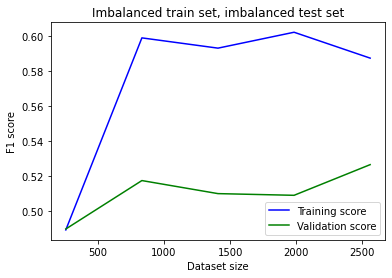

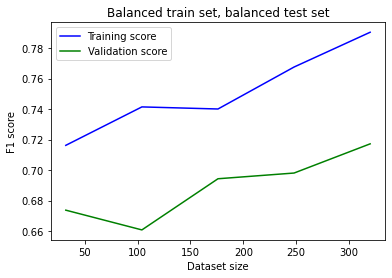

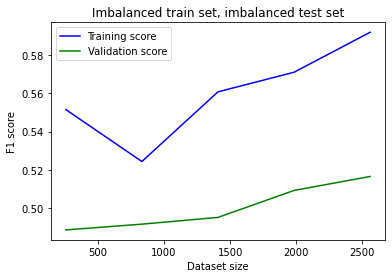

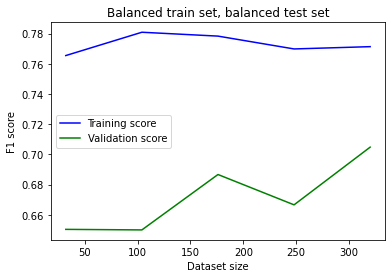

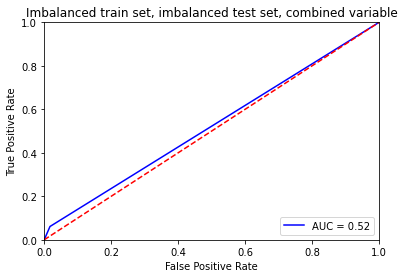

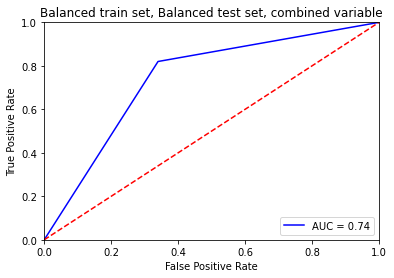

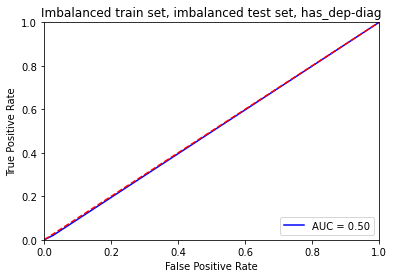

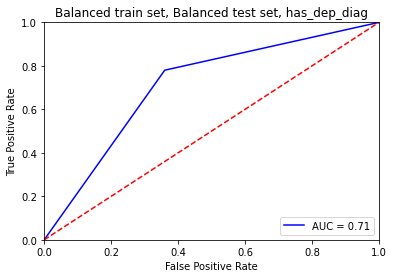

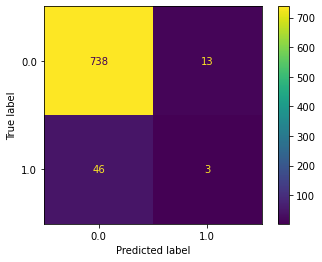

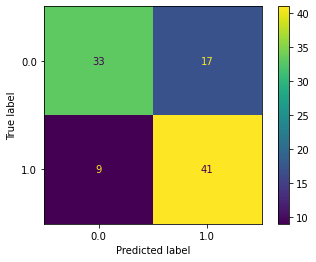

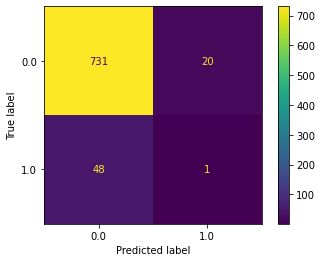

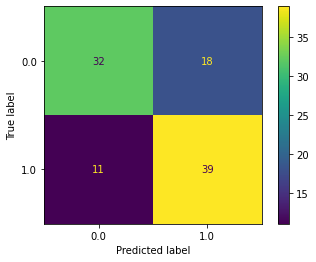

In [168]:
print_metrics(knn, X_train_comb_imb, y_train_comb_imb, X_test_comb_imb, y_test_comb_imb, "KNN, combined, imbalanced")
print_metrics(knn, X_train_comb_b, y_train_comb_b, X_test_comb_b, y_test_comb_b, "KNN, combined, balanced")
print_metrics(knn, X_train_hasdep_imb, y_train_hasdep_imb, X_test_hasdep_imb, y_test_hasdep_imb, "KNN, has_dep_diag, imbalanced")
print_metrics(knn, X_train_hasdep_b, y_train_hasdep_b, X_test_hasdep_b, y_test_hasdep_b, "KNN, has_dep_diag, balanced")

plot_learning_curve(5, knn, X_train_comb_imb, y_train_comb_imb, 'Imbalanced train set, imbalanced test set')
plot_learning_curve(5, knn, X_train_comb_b, y_train_comb_b, 'Balanced train set, balanced test set')
plot_learning_curve(5, knn, X_train_hasdep_imb, y_train_hasdep_imb, 'Imbalanced train set, imbalanced test set')
plot_learning_curve(5, knn, X_train_hasdep_b, y_train_hasdep_b, 'Balanced train set, balanced test set')

plot_roc(knn, X_train_comb_imb, y_train_comb_imb, X_test_comb_imb, y_test_comb_imb, "Imbalanced train set, imbalanced test set, combined variable")
plot_roc(knn, X_train_comb_b, y_train_comb_b, X_test_comb_b, y_test_comb_b, "Balanced train set, Balanced test set, combined variable")
plot_roc(knn, X_train_hasdep_imb, y_train_hasdep_imb, X_test_hasdep_imb, y_test_hasdep_imb, "Imbalanced train set, imbalanced test set, has_dep-diag")
plot_roc(knn, X_train_hasdep_b, y_train_hasdep_b, X_test_hasdep_b, y_test_hasdep_b, "Balanced train set, Balanced test set, has_dep_diag")

plot_cf(knn, X_train_comb_imb, y_train_comb_imb, X_test_comb_imb, y_test_comb_imb)
plot_cf(knn, X_train_comb_b, y_train_comb_b, X_test_comb_b, y_test_comb_b)
plot_cf(knn, X_train_hasdep_imb, y_train_hasdep_imb, X_test_hasdep_imb, y_test_hasdep_imb)
plot_cf(knn, X_train_hasdep_b, y_train_hasdep_b, X_test_hasdep_b, y_test_hasdep_b)

### SVM

In [169]:
from sklearn import svm
from sklearn.svm import SVC

svm = SVC(C=5, gamma='auto', kernel='rbf')

SVM, combined, imbalanced: 
F1: 0.5188749074759438
recall: 0.517079268458382
precision: 0.6132228427310394
accuracy: 0.935
SVM, combined, balanced: 
F1: 0.7390606182256123
recall: 0.74
precision: 0.7435064935064934
accuracy: 0.74
SVM, has_dep_diag, imbalanced: 
F1: 0.4828700711053653
recall: 0.4973368841544607
precision: 0.4692211055276382
accuracy: 0.93375
SVM, has_dep_diag, balanced: 
F1: 0.6989160979526294
recall: 0.7
precision: 0.702922077922078
accuracy: 0.7


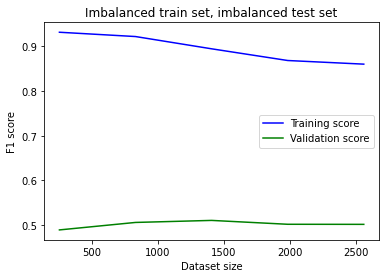

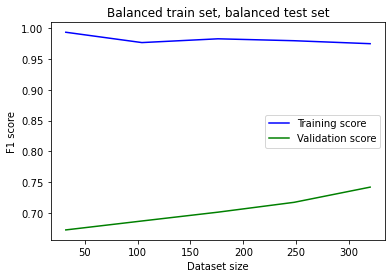

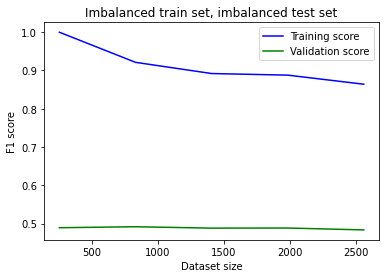

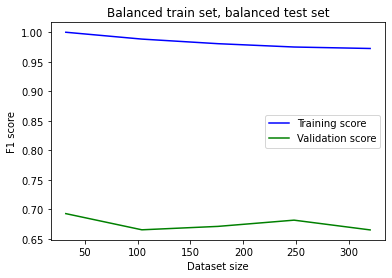

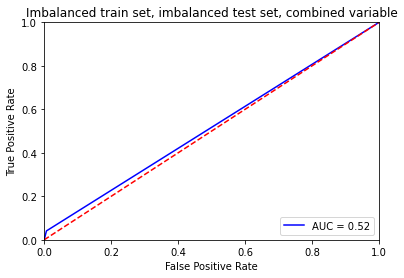

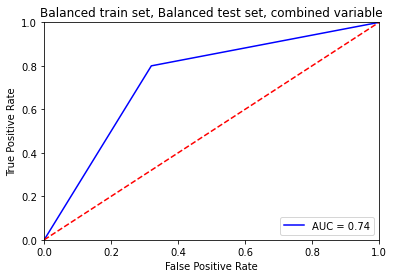

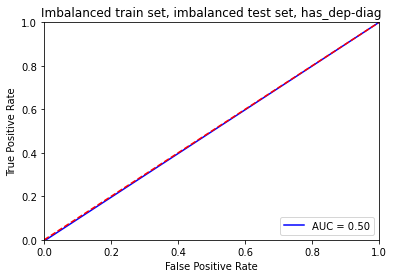

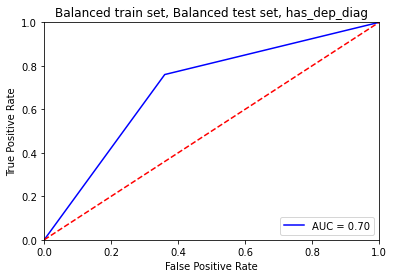

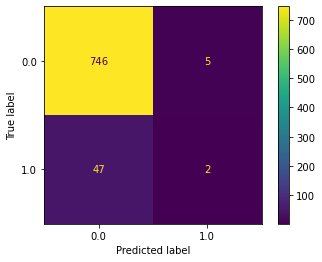

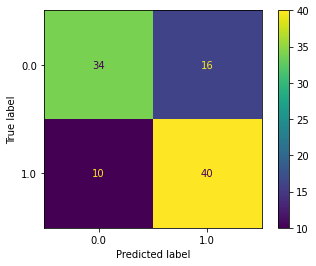

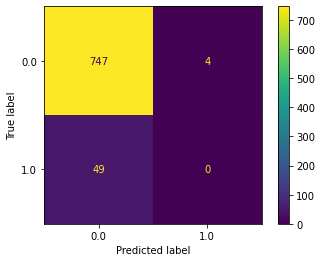

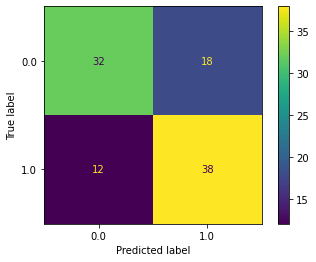

In [170]:
print_metrics(svm, X_train_comb_imb, y_train_comb_imb, X_test_comb_imb, y_test_comb_imb, "SVM, combined, imbalanced")
print_metrics(svm, X_train_comb_b, y_train_comb_b, X_test_comb_b, y_test_comb_b, "SVM, combined, balanced")
print_metrics(svm, X_train_hasdep_imb, y_train_hasdep_imb, X_test_hasdep_imb, y_test_hasdep_imb, "SVM, has_dep_diag, imbalanced")
print_metrics(svm, X_train_hasdep_b, y_train_hasdep_b, X_test_hasdep_b, y_test_hasdep_b, "SVM, has_dep_diag, balanced")

plot_learning_curve(5, svm, X_train_comb_imb, y_train_comb_imb, 'Imbalanced train set, imbalanced test set')
plot_learning_curve(5, svm, X_train_comb_b, y_train_comb_b, 'Balanced train set, balanced test set')
plot_learning_curve(5, svm, X_train_hasdep_imb, y_train_hasdep_imb, 'Imbalanced train set, imbalanced test set')
plot_learning_curve(5, svm, X_train_hasdep_b, y_train_hasdep_b, 'Balanced train set, balanced test set')

plot_roc(svm, X_train_comb_imb, y_train_comb_imb, X_test_comb_imb, y_test_comb_imb, "Imbalanced train set, imbalanced test set, combined variable")
plot_roc(svm, X_train_comb_b, y_train_comb_b, X_test_comb_b, y_test_comb_b, "Balanced train set, Balanced test set, combined variable")
plot_roc(svm, X_train_hasdep_imb, y_train_hasdep_imb, X_test_hasdep_imb, y_test_hasdep_imb, "Imbalanced train set, imbalanced test set, has_dep-diag")
plot_roc(svm, X_train_hasdep_b, y_train_hasdep_b, X_test_hasdep_b, y_test_hasdep_b, "Balanced train set, Balanced test set, has_dep_diag")

plot_cf(svm, X_train_comb_imb, y_train_comb_imb, X_test_comb_imb, y_test_comb_imb)
plot_cf(svm, X_train_comb_b, y_train_comb_b, X_test_comb_b, y_test_comb_b)
plot_cf(svm, X_train_hasdep_imb, y_train_hasdep_imb, X_test_hasdep_imb, y_test_hasdep_imb)
plot_cf(svm, X_train_hasdep_b, y_train_hasdep_b, X_test_hasdep_b, y_test_hasdep_b)

### FNN

In [171]:
from keras.models import Sequential
from keras.layers import Dense

import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout

def NN_Model_Dropout(neuron, activation, in_shape, classes, output_activation, optimizer, loss, dr):

    model = models.Sequential()

    ##Input Layer
    model.add(Dense(37, activation = activation, input_shape = in_shape))

    #Hidden Layers
    for i in neuron:

        model.add(Dense(i, activation = activation))
        #model.add(Dropout(dr))

    ##Ouput Layer
    model.add(Dense(classes, activation = output_activation))

    ##Compiling
    model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics=['acc'])

    return model

from sklearn.model_selection import train_test_split
X_train_comb_imb, X_val_test_comb_imb, y_train_comb_imb, y_val_test_comb_imb = train_test_split(X_combined_imb, Y_combined_imb, test_size = 0.3, random_state = 40)
X_val_comb_imb, X_test_comb_imb, y_val_comb_imb, y_test_comb_imb = train_test_split(X_val_test_comb_imb, y_val_test_comb_imb, test_size = 0.5, random_state = 40)

print("X_train_comb_imb:", X_train_comb_imb.shape)
print("y_train_comb_imb:", y_train_comb_imb.shape)
print("X_val_comb_imb:", X_val_comb_imb.shape)
print("X_test_comb_imb:", X_test_comb_imb.shape)
print("y_val_comb_imb:", y_val_comb_imb.shape)
print("y_test_comb_imb:", y_test_comb_imb.shape)

#combined, balanced, undersampling
X_train_comb_b, X_val_test_comb_b, y_train_comb_b, y_val_test_comb_b = train_test_split(X_combined_b, Y_combined_b, test_size = 0.3, random_state = 40)
X_val_comb_b, X_test_comb_b, y_val_comb_b, y_test_comb_b = train_test_split(X_val_test_comb_b, y_val_test_comb_b, test_size = 0.5, random_state = 40)

print("X_train_comb_b:", X_train_comb_b.shape)
print("y_train_comb_b:", y_train_comb_b.shape)
print("X_val_comb_b:", X_val_comb_b.shape)
print("X_test_comb_b:", X_test_comb_b.shape)
print("y_val_comb_b:", y_val_comb_b.shape)
print("y_test_comb_b:", y_test_comb_b.shape)

#has_dep_diag, imbalanced (original ratio), undersampling
X_train_hasdep_imb, X_val_test_hasdep_imb, y_train_hasdep_imb, y_val_test_hasdep_imb = train_test_split(X_hasdep_imb, Y_hasdep_imb, test_size = 0.3, random_state = 40)
X_val_hasdep_imb, X_test_hasdep_imb, y_val_hasdep_imb, y_test_hasdep_imb = train_test_split(X_val_test_hasdep_imb, y_val_test_hasdep_imb, test_size = 0.5, random_state = 40)

print("X_train_hasdep_imb:", X_train_hasdep_imb.shape)
print("y_train_hasdep_imb:", y_train_hasdep_imb.shape)
print("X_val_hasdep_imb:", X_val_hasdep_imb.shape)
print("X_test_hasdep_imb:", X_test_hasdep_imb.shape)
print("y_val_hasdep_imb:", y_val_hasdep_imb.shape)
print("y_test_hasdep_imb:", y_test_hasdep_imb.shape)

#has_dep_diag, balanced, undersampling
X_train_hasdep_b, X_val_test_hasdep_b, y_train_hasdep_b, y_val_test_hasdep_b = train_test_split(X_hasdep_b, Y_hasdep_b, test_size = 0.3, random_state = 40)
X_val_hasdep_b, X_test_hasdep_b, y_val_hasdep_b, y_test_hasdep_b = train_test_split(X_val_test_hasdep_b, y_val_test_hasdep_b, test_size = 0.5, random_state = 40)

print("X_train_hasdep_b:", X_train_hasdep_b.shape)
print("y_train_hasdep_b:", y_train_hasdep_b.shape)
print("X_val_hasdep_b:", X_val_hasdep_b.shape)
print("X_test_hasdep_b:", X_test_hasdep_b.shape)
print("y_val_hasdep_b:", y_val_hasdep_b.shape)
print("y_test_hasdep_b:", y_test_hasdep_b.shape)

##from FFNeuralNetwork import NN_models

neurons = [35, 35]
fnn = NN_Model_Dropout(neuron = neurons, activation = 'relu', in_shape = (35,), classes = 2, output_activation = 'sigmoid', optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', dr = 0.4)
final_history = fnn.fit(X_train_comb_imb, y_train_comb_imb, epochs = 100, validation_data = (X_val_comb_imb, y_val_comb_imb), verbose = 0)
score = fnn.evaluate(X_test_comb_imb, y_test_comb_imb, verbose = 0, batch_size = 32)
print(score)


ModuleNotFoundError: No module named 'keras'

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    f1 = 2*((precision*recall)/(precision+recall+K.epsilon()))
    return f1

def fnn_print_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    model.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), verbose = 0)
    preds = model.predict(X_test)
    preds_choice = preds.argmax(1)
    #preds_choice = preds[:, 0]
    #f1 = f1_m(y_test, preds_choice)
    f1 = f1_score(y_test, preds_choice, average = 'macro')
    recall = recall_score(y_test, preds_choice, average = 'macro')
    precision = precision_score(y_test, preds_choice, average = 'macro')
    print(model_name + ': ')
    #print(f'F1: {f1}')
    #print(f'recall: {recall_m(y_test, preds_choice)}')
    #print(f'precision: {precision_m(y_test, preds_choice)}')
    print(f'F1: {f1}')
    print(f'recall: {recall}')
    print(f'precision: {precision}')

In [ ]:
fnn_print_metrics(fnn, X_train_comb_imb, y_train_comb_imb, X_val_comb_imb, y_val_comb_imb, X_test_comb_imb, y_test_comb_imb, "FNN, combined, imbalanced")
fnn_print_metrics(fnn, X_train_comb_b, y_train_comb_b, X_val_comb_b, y_val_comb_b, X_test_comb_imb, y_test_comb_imb, "FNN, combined, b/imb")
fnn_print_metrics(fnn, X_train_comb_b, y_train_comb_b, X_val_comb_b, y_val_comb_b, X_test_comb_b, y_test_comb_b, "FNN, combined, balanced")
fnn_print_metrics(fnn, X_train_hasdep_imb, y_train_hasdep_imb, X_val_hasdep_imb, y_val_hasdep_imb, X_test_hasdep_imb, y_test_hasdep_imb, "FNN, has_dep_diag, imbalanced")
fnn_print_metrics(fnn, X_train_hasdep_b, y_train_hasdep_b, X_val_hasdep_b, y_val_hasdep_b, X_test_hasdep_b, y_test_hasdep_b, "FNN, has_dep_diag, balanced")

### XGBoost

In [ ]:
from sklearn.metrics import mean_absolute_error
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn import metrics 
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
#from xgboost import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from pandas import MultiIndex, Int64Index
import warnings
warnings.filterwarnings('ignore')


def modelfit(alg, dtrain_X, dtrain_Y, dtest_X, dtest_Y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):


    xgb_param = alg.get_xgb_params()
        
    xgtrain = xgb.DMatrix(dtrain_X, dtrain_Y)
    xgtest_X = xgb.DMatrix(dtest_X)
    xgtest_Y = xgb.DMatrix(dtest_Y)
        
    cvresult = xgb.cv(xgb_param, 
                     xgtrain, 
                     num_boost_round=alg.get_params()['n_estimators'], 
                     nfold=cv_folds, 
                      metrics='auc',
                    early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])
    
    alg.fit(dtrain_X, dtrain_Y,eval_metric=['logloss','auc','error'])

    # pred
    dtrain_predictions = alg.predict(dtest_X)
    dtrain_predprob = alg.predict_proba(dtest_X)[:,1]

    print ("f1 : %.4g" % metrics.f1_score(dtest_Y, dtrain_predictions, average = 'macro'))
    return metrics.f1_score(dtest_Y, dtrain_predictions, average = 'macro')



xgbc = XGBClassifier(n_estimators=1000,
                         learning_rate=0.05, 
                         n_jobs=4,
                         max_depth = 16,
                         min_child_weight = 1,
                         gamma = 0.2,
                         subsample=0.97, 
                         colsample_bytree=0.73,
                         reg_alpha = 3.64,
                         seed=1024,
                         use_label_encoder=False)




#combined variable

#train imbalanced, test imbalanced
modelfit(xgbc, X_train_comb_imb, y_train_comb_imb, X_test_comb_imb, y_test_comb_imb)

#train imbalanced, test balanced
modelfit(xgbc, X_train_comb_imb, y_train_comb_imb, X_test_comb_b, y_test_comb_b)

#train balanced, test imbalanced
modelfit(xgbc, X_train_comb_b, y_train_comb_b, X_test_comb_imb, y_test_comb_imb)

#train balanced, test balanced
modelfit(xgbc, X_train_comb_b, y_train_comb_b, X_test_comb_b, y_test_comb_b)


#has_dep_diag

#train imbalanced, test imbalanced
#modelfit(xgbc, X_train_hasdep_imb, y_train_hasdep_imb, X_test_hasdep_imb, y_test_hasdep_imb.reshape(600, 1))

#train imbalanced, test balanced
#modelfit(xgbc, X_train_hasdep_imb, y_train_hasdep_imb, X_test_hasdep_b, y_test_hasdep_b.reshape(75, 1))

#train balanced, test imbalanced
#modelfit(xgbc, X_train_hasdep_b, y_train_hasdep_b, X_test_hasdep_imb, y_test_hasdep_imb.reshape(600, 1))

#train balanced, test balanced
#modelfit(xgbc, X_train_hasdep_b, y_train_hasdep_b, X_test_hasdep_b, y_test_hasdep_b.reshape(75, 1))

## Model comparison

In [ ]:
bar_x = np.arange(5)
bar_y = np.array([])
imbimb = []
bimb = []
imbb = []
bb = []
lr = []
clf.fit(X_train_comb_imb, y_train_comb_imb)
y_pred = clf.predict(X_test_comb_imb)
f1 = f1_score(y_pred, y_test_comb_imb, average = "macro")
imbimb = np.append(imbimb, f1)

clf.fit(X_train_comb_b, y_train_comb_b)
y_pred = clf.predict(X_test_comb_imb)
f1 = f1_score(y_pred, y_test_comb_imb, average = "macro")
bimb = np.append(bimb, f1)

clf.fit(X_train_comb_imb, y_train_comb_imb)
y_pred = clf.predict(X_test_comb_b)
f1 = f1_score(y_pred, y_test_comb_b, average = "macro")
imbb = np.append(imbb, f1)

clf.fit(X_train_comb_b, y_train_comb_b)
y_pred = clf.predict(X_test_comb_b)
f1 = f1_score(y_pred, y_test_comb_b, average = "macro")
bb = np.append(bb, f1)

#bar_y = np.append(bar_y, lr)

k = []

knn.fit(X_train_comb_imb, y_train_comb_imb)
y_pred = knn.predict(X_test_comb_imb)
f1 = f1_score(y_pred, y_test_comb_imb, average = "macro")
imbimb = np.append(imbimb, f1)

knn.fit(X_train_comb_b, y_train_comb_b)
y_pred = knn.predict(X_test_comb_imb)
f1 = f1_score(y_pred, y_test_comb_imb, average = "macro")
bimb = np.append(bimb, f1)

knn.fit(X_train_comb_imb, y_train_comb_imb)
y_pred = knn.predict(X_test_comb_b)
f1 = f1_score(y_pred, y_test_comb_b, average = "macro")
imbb = np.append(imbb, f1)

knn.fit(X_train_comb_b, y_train_comb_b)
y_pred = knn.predict(X_test_comb_b)
f1 = f1_score(y_pred, y_test_comb_b, average = "macro")
bb = np.append(bb, f1)

#bar_y = np.append(bar_y, k)

sv = []

svm.fit(X_train_comb_imb, y_train_comb_imb)
y_pred = svm.predict(X_test_comb_imb)
f1 = f1_score(y_pred, y_test_comb_imb, average = "macro")
imbimb = np.append(imbimb, f1)

svm.fit(X_train_comb_b, y_train_comb_b)
y_pred = svm.predict(X_test_comb_imb)
f1 = f1_score(y_pred, y_test_comb_imb, average = "macro")
bimb = np.append(bimb, f1)

svm.fit(X_train_comb_imb, y_train_comb_imb)
y_pred = svm.predict(X_test_comb_b)
f1 = f1_score(y_test_comb_b, y_pred, average = "macro")
imbb = np.append(imbb, f1)

svm.fit(X_train_comb_b, y_train_comb_b)
y_pred = svm.predict(X_test_comb_b)
f1 = f1_score(y_pred, y_test_comb_b, average = "macro")
bb = np.append(bb, f1)

#bar_y = np.append(bar_y, sv)

imbimb = np.append(imbimb, modelfit(xgbc, X_train_comb_imb, y_train_comb_imb, X_test_comb_imb, y_test_comb_imb))

#train imbalanced, test balanced
imbb = np.append(imbb, modelfit(xgbc, X_train_comb_imb, y_train_comb_imb, X_test_comb_b, y_test_comb_b))

#train balanced, test imbalanced
bimb = np.append(bimb, modelfit(xgbc, X_train_comb_b, y_train_comb_b, X_test_comb_imb, y_test_comb_imb))

#train balanced, test balanced
bb = np.append(bb, modelfit(xgbc, X_train_comb_b, y_train_comb_b, X_test_comb_b, y_test_comb_b))


fn = []
fnn.fit(X_train_comb_imb, y_train_comb_imb, epochs = 100, validation_data = (X_val_comb_imb, y_val_comb_imb), verbose = 0)
preds = fnn.predict(X_test_comb_imb)
preds_choice = preds.argmax(1)
f1 = f1_score(y_test_comb_imb, preds_choice, average = 'macro')
imbimb = np.append(imbimb, f1)

fnn.fit(X_train_comb_imb, y_train_comb_imb, epochs = 100, validation_data = (X_val_comb_imb, y_val_comb_imb), verbose = 0)
preds = fnn.predict(X_test_comb_b)
preds_choice = preds.argmax(1)
f1 = f1_score(y_test_comb_b, preds_choice, average = 'macro')
imbb = np.append(imbb, f1)

fnn.fit(X_train_comb_b, y_train_comb_b, epochs = 100, validation_data = (X_val_comb_b, y_val_comb_b), verbose = 0)
preds = fnn.predict(X_test_comb_imb)
preds_choice = preds.argmax(1)
f1 = f1_score(y_test_comb_imb, preds_choice, average = 'macro')
bimb = np.append(bimb, f1)

fnn.fit(X_train_comb_b, y_train_comb_b, epochs = 100, validation_data = (X_val_comb_b, y_val_comb_b), verbose = 0)
preds = fnn.predict(X_test_comb_b)
preds_choice = preds.argmax(1)
f1 = f1_score(y_test_comb_b, preds_choice, average = 'macro')
bb = np.append(bb, f1)

In [ ]:
plt.bar(bar_x-0.2, imbimb, 0.2, color='yellow')
plt.bar(bar_x, bimb, 0.2, color='orange')
plt.bar(bar_x+0.2, imbb, 0.2, color='green')
plt.bar(bar_x+0.4, bb, 0.2, color='red')
plt.title('Comparison of different models on different dataset splits')
plt.legend(["Imbalanced train set, imbalanced test set", "Balanced train set, imbalanced test set", "Imbalanced train set, balanced test set", "Balanced train set, balanced test set"])
plt.xticks(bar_x, ['LR', 'KNN', 'SVM', "XGB", "FNN"])
plt.xlabel('models')
plt.ylabel('F1 score')
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()